c:\Users\duyde\anaconda3\envs\zest\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Số mẫu test: 40
Accuracy on test set: 95.00%
Classification Report:
              precision    recall  f1-score   support

   Thơ người       1.00      0.90      0.95        20
      Thơ AI       0.91      1.00      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40

Confusion Matrix:
[[18  2]
 [ 0 20]]


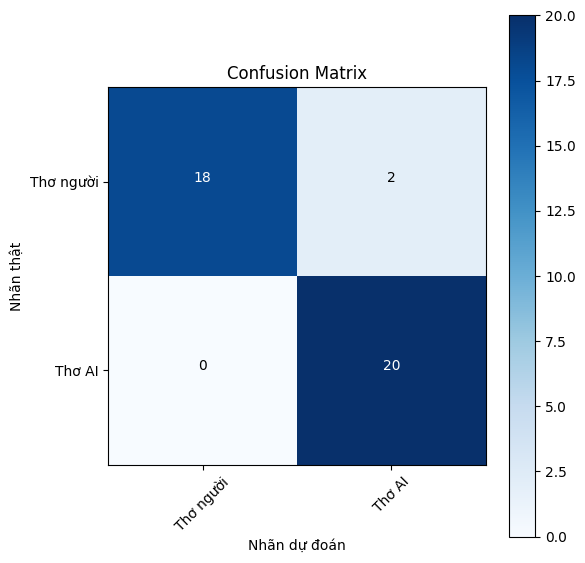

In [1]:
import os
import glob
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Đường dẫn tới folder test và model đã lưu
TEST_DIR = r"D:\Bao_Duy\NLP\data_test"
MODEL_DIR = r"D:\Bao_Duy\NLP\model_final"

# Thiết lập device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tải tokenizer và model từ thư mục đã lưu
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.to(device)
model.eval()

def classify_poem(text, max_length=256):
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        pred = torch.argmax(probs, dim=1).item()
    return pred

def load_test_data(test_dir):
    texts = []
    labels = []
    # Giả sử cấu trúc folder: test_dir/human/*.txt và test_dir/AI/*.txt
    human_dir = os.path.join(test_dir, "human")
    ai_dir = os.path.join(test_dir, "AI")
    
    for filepath in glob.glob(os.path.join(human_dir, "*.txt")):
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read().strip()
            if text:
                texts.append(text)
                labels.append(0)  # 0: Thơ do người viết
                
    for filepath in glob.glob(os.path.join(ai_dir, "*.txt")):
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read().strip()
            if text:
                texts.append(text)
                labels.append(1)  # 1: Thơ do AI viết
                
    return texts, labels

# Load dữ liệu test
test_texts, test_labels = load_test_data(TEST_DIR)
print("Số mẫu test:", len(test_labels))

if len(test_labels) == 0:
    print("Không có dữ liệu test nào được load. Kiểm tra lại folder:", TEST_DIR)
else:
    # Dự đoán nhãn cho dữ liệu test
    pred_labels = []
    for text in test_texts:
        pred = classify_poem(text)
        pred_labels.append(pred)

    # Tính toán độ chính xác và in báo cáo phân lớp
    acc = accuracy_score(test_labels, pred_labels)
    print("Accuracy on test set: {:.2f}%".format(acc * 100))
    print("Classification Report:")
    print(classification_report(test_labels, pred_labels, labels=[0,1], target_names=["Thơ người", "Thơ AI"]))

    # Tính confusion matrix
    cm = confusion_matrix(test_labels, pred_labels)
    print("Confusion Matrix:")
    print(cm)

    # Vẽ confusion matrix bằng matplotlib
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Thơ người", "Thơ AI"], rotation=45)
    plt.yticks(tick_marks, ["Thơ người", "Thơ AI"])

    # Kiểm tra nếu ma trận không rỗng để tránh lỗi
    if cm.size:
        thresh = cm.max() / 2.0
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, format(cm[i, j], 'd'),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel("Nhãn thật")
    plt.xlabel("Nhãn dự đoán")
    plt.tight_layout()
    plt.show()
